In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [31]:
from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [92]:
class SaveImagesCallback(Callback):
    def __init__(self, logdir):
        self.logdir = Path(logdir)
        
        self.logdir.mkdir(exist_ok=True, parents=True)
            
    def on_epoch_end(self, epoch, logs= None):
        generator = self.model.generator
        test_input = tf.random.normal([batch_size, 128])
        predictions = generator(test_input, training=False)
        pred_16_index = np.random.choice(np.array(list(range(predictions.shape[0]))), size= 16)
        predictions = np.array([predictions[x, :, :, :] for x in pred_16_index])
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(np.asarray(predictions[i, :, :, :] * 255.0, dtype= np.uint8), cmap='gray')
            plt.axis('off')

        plt.savefig(f'{str(self.logdir)}/tf_image_at_epoch_{epoch:04d}.png')
        plt.show()

In [93]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = self.batch_size
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

Epoch 1/100
100/100 [==============================] - 4s 28ms/step - d_loss: 0.6219 - g_loss: 0.9458


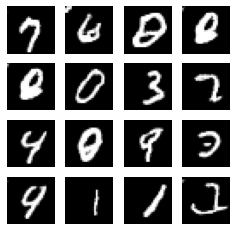

Epoch 2/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6220 - g_loss: 0.9347


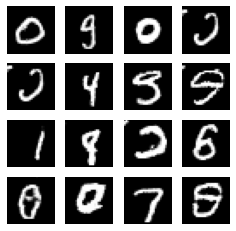

Epoch 3/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6186 - g_loss: 0.9374


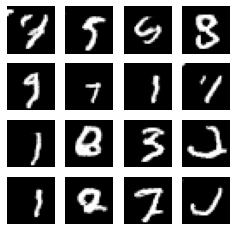

Epoch 4/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6221 - g_loss: 0.9418


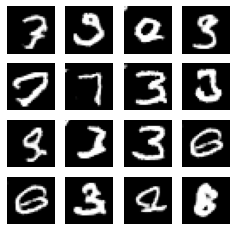

Epoch 5/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6188 - g_loss: 0.9427


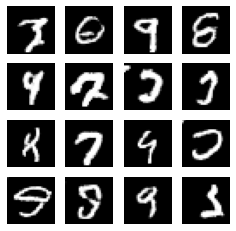

Epoch 6/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6203 - g_loss: 0.9476


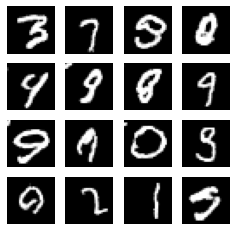

Epoch 7/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6203 - g_loss: 0.9427


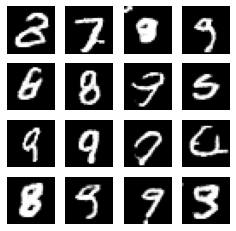

Epoch 8/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6188 - g_loss: 0.9363


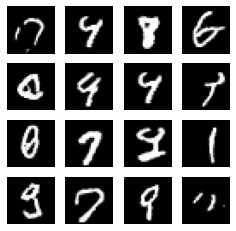

Epoch 9/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6192 - g_loss: 0.9387


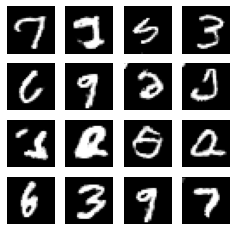

Epoch 10/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6167 - g_loss: 0.9462


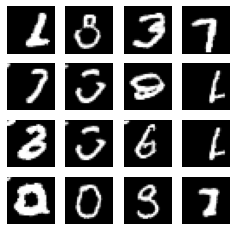

Epoch 11/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6223 - g_loss: 0.9534


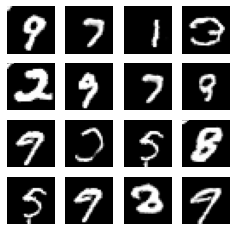

Epoch 12/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6198 - g_loss: 0.9437


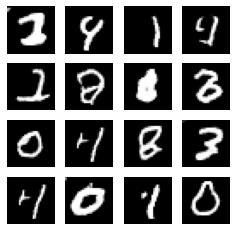

Epoch 13/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6186 - g_loss: 0.9512


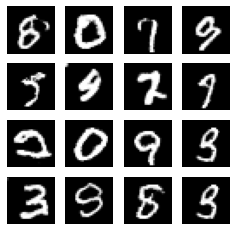

Epoch 14/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6177 - g_loss: 0.9526


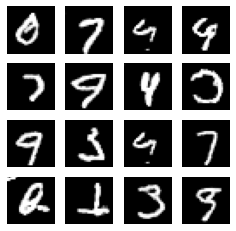

Epoch 15/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6192 - g_loss: 0.9420


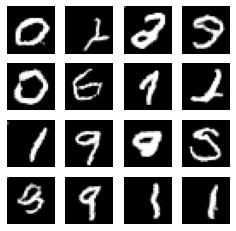

Epoch 16/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6169 - g_loss: 0.9617


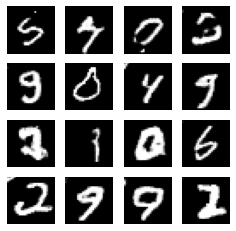

Epoch 17/100
100/100 [==============================] - 3s 31ms/step - d_loss: 0.6207 - g_loss: 0.9505


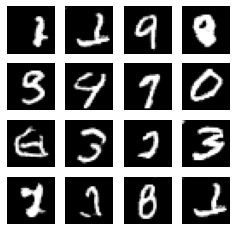

Epoch 18/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6162 - g_loss: 0.9544


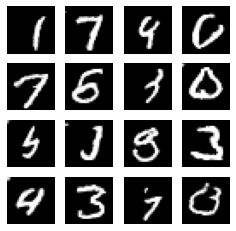

Epoch 19/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6163 - g_loss: 0.9554


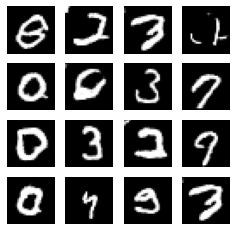

Epoch 20/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6196 - g_loss: 0.9477


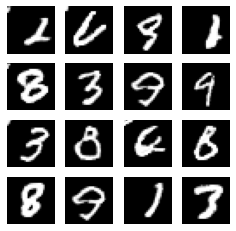

Epoch 21/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6186 - g_loss: 0.9460


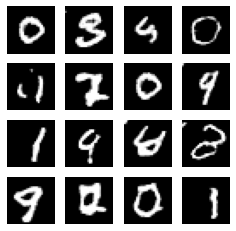

Epoch 22/100
100/100 [==============================] - 3s 28ms/step - d_loss: 0.6181 - g_loss: 0.9564


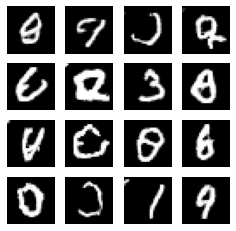

Epoch 23/100
100/100 [==============================] - 3s 29ms/step - d_loss: 0.6139 - g_loss: 0.9536


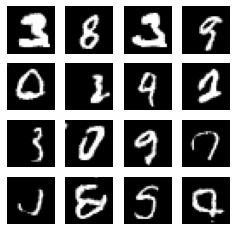

Epoch 24/100
100/100 [==============================] - 3s 29ms/step - d_loss: 0.6209 - g_loss: 0.9627


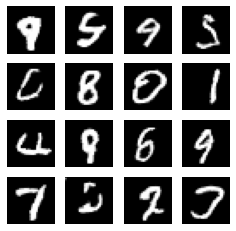

Epoch 25/100
100/100 [==============================] - 3s 30ms/step - d_loss: 0.6147 - g_loss: 0.9558


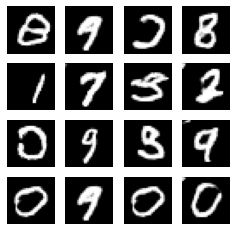

Epoch 26/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6174 - g_loss: 0.9563


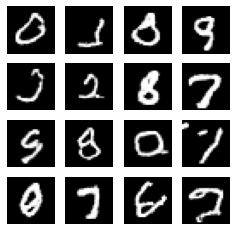

Epoch 27/100
100/100 [==============================] - 3s 30ms/step - d_loss: 0.6189 - g_loss: 0.9547


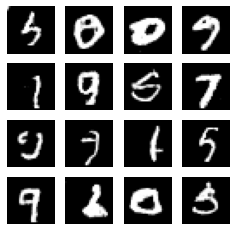

Epoch 28/100
100/100 [==============================] - 3s 30ms/step - d_loss: 0.6170 - g_loss: 0.9509


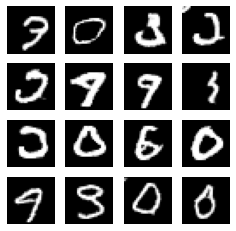

Epoch 29/100
100/100 [==============================] - 3s 31ms/step - d_loss: 0.6203 - g_loss: 0.9562


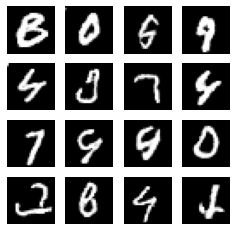

Epoch 30/100
100/100 [==============================] - 3s 30ms/step - d_loss: 0.6183 - g_loss: 0.9526


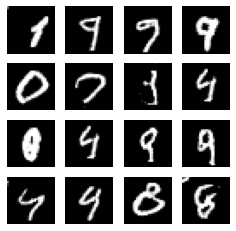

Epoch 31/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6151 - g_loss: 0.9399


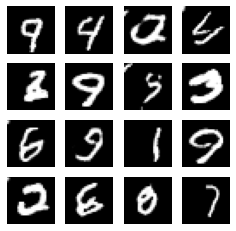

Epoch 32/100
100/100 [==============================] - 3s 31ms/step - d_loss: 0.6163 - g_loss: 0.9501


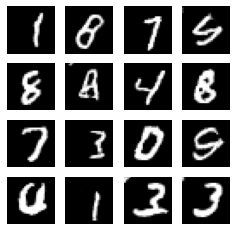

Epoch 33/100
100/100 [==============================] - 3s 31ms/step - d_loss: 0.6204 - g_loss: 0.9509


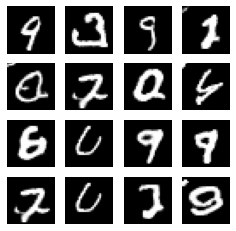

Epoch 34/100
100/100 [==============================] - 3s 31ms/step - d_loss: 0.6153 - g_loss: 0.9526


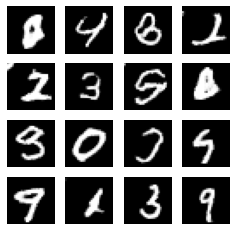

Epoch 35/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6148 - g_loss: 0.9694


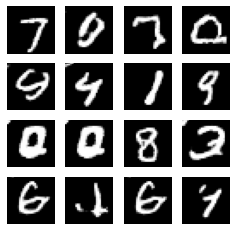

Epoch 36/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6174 - g_loss: 0.9580


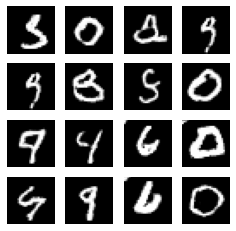

Epoch 37/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6177 - g_loss: 0.9683


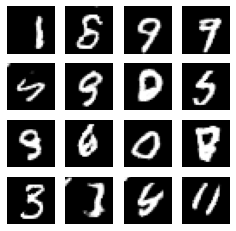

Epoch 38/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6135 - g_loss: 0.9676


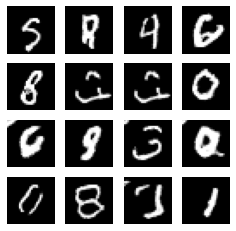

Epoch 39/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6176 - g_loss: 0.9604


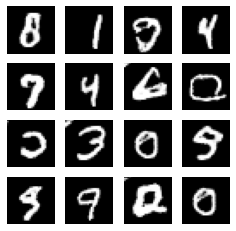

Epoch 40/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6137 - g_loss: 0.9567


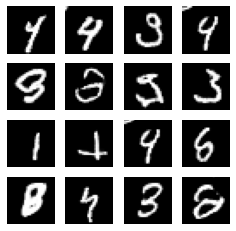

Epoch 41/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6165 - g_loss: 0.9475


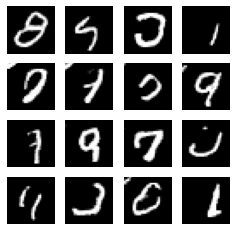

Epoch 42/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6168 - g_loss: 0.9579


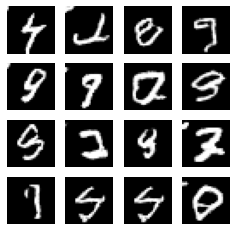

Epoch 43/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6137 - g_loss: 0.9473


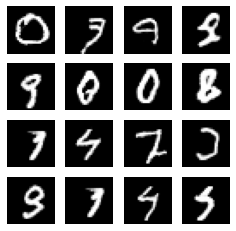

Epoch 44/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6183 - g_loss: 0.9541


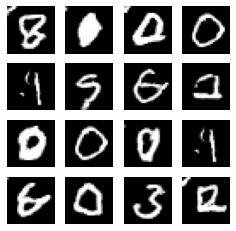

Epoch 45/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6181 - g_loss: 0.9565


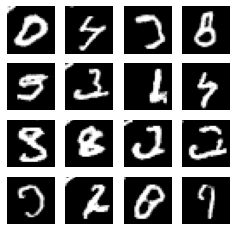

Epoch 46/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6122 - g_loss: 0.9594


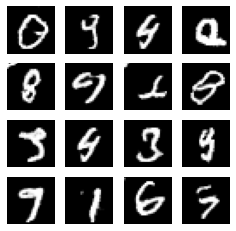

Epoch 47/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6164 - g_loss: 0.9604


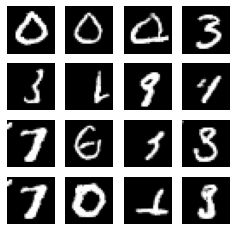

Epoch 48/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6156 - g_loss: 0.9505


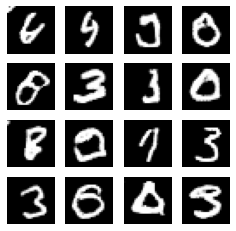

Epoch 49/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6147 - g_loss: 0.9632


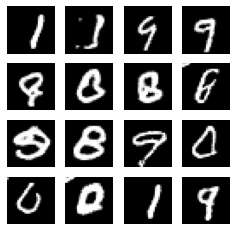

Epoch 50/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6127 - g_loss: 0.9552


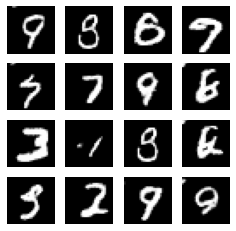

Epoch 51/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6131 - g_loss: 0.9598


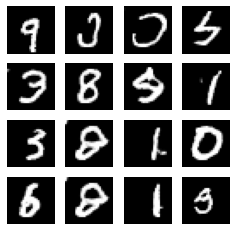

Epoch 52/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6122 - g_loss: 0.9692


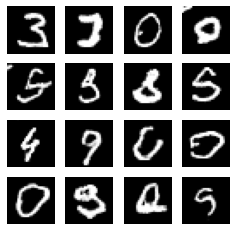

Epoch 53/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6168 - g_loss: 0.9538


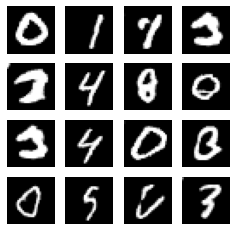

Epoch 54/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6176 - g_loss: 0.9643


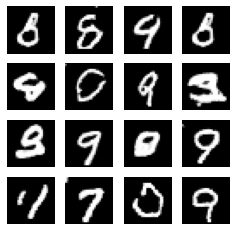

Epoch 55/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6132 - g_loss: 0.9761


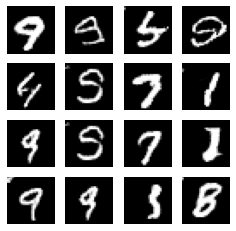

Epoch 56/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6115 - g_loss: 0.9695


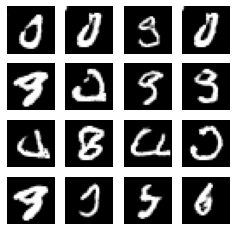

Epoch 57/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6144 - g_loss: 0.9582


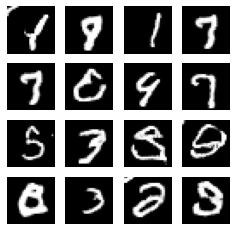

Epoch 58/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6114 - g_loss: 0.9585


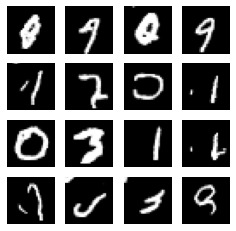

Epoch 59/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6144 - g_loss: 0.9571


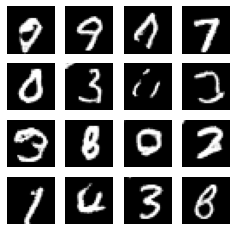

Epoch 60/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6151 - g_loss: 0.9570


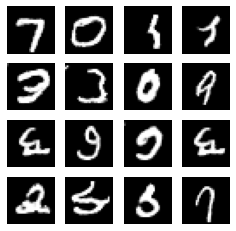

Epoch 61/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6140 - g_loss: 0.9601


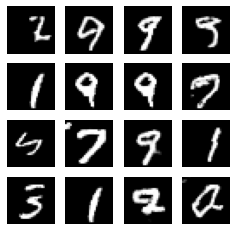

Epoch 62/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6122 - g_loss: 0.9497


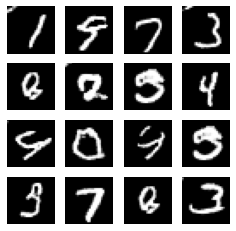

Epoch 63/100
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6123 - g_loss: 0.9562


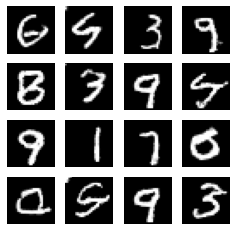

Epoch 64/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6159 - g_loss: 0.9580


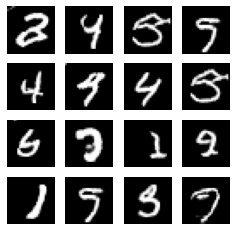

Epoch 65/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6133 - g_loss: 0.9536


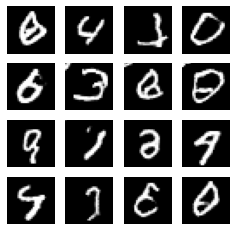

Epoch 66/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6154 - g_loss: 0.9578


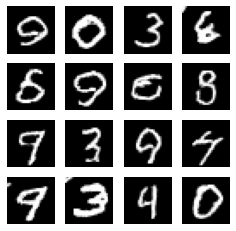

Epoch 67/100
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6153 - g_loss: 0.9628


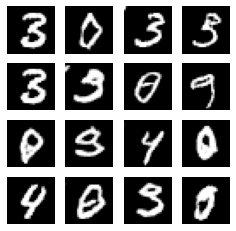

Epoch 68/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6150 - g_loss: 0.9702


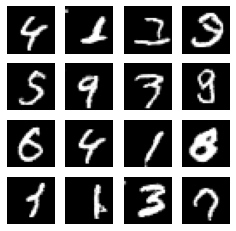

Epoch 69/100
100/100 [==============================] - 3s 33ms/step - d_loss: 0.6114 - g_loss: 0.9740


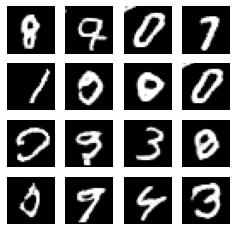

Epoch 70/100
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6109 - g_loss: 0.9711


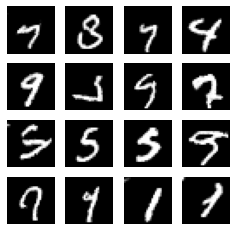

Epoch 71/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6148 - g_loss: 0.9604


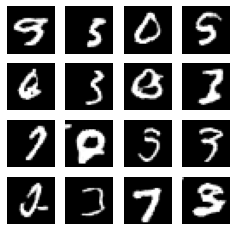

Epoch 72/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6141 - g_loss: 0.9627


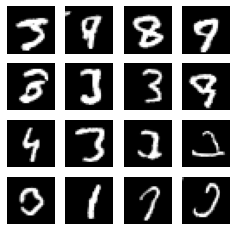

Epoch 73/100
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6160 - g_loss: 0.9582


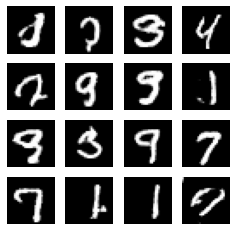

Epoch 74/100
100/100 [==============================] - 4s 39ms/step - d_loss: 0.6125 - g_loss: 0.9667


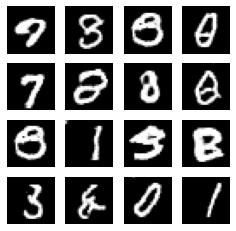

Epoch 75/100
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6119 - g_loss: 0.9720 0s - d_l


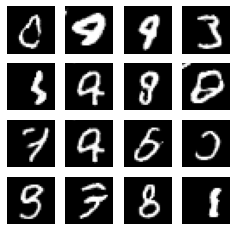

Epoch 76/100
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6121 - g_loss: 0.9576


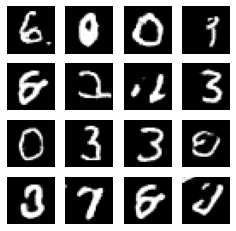

Epoch 77/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6153 - g_loss: 0.9529


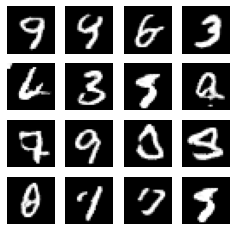

Epoch 78/100
100/100 [==============================] - 4s 38ms/step - d_loss: 0.6182 - g_loss: 0.9646


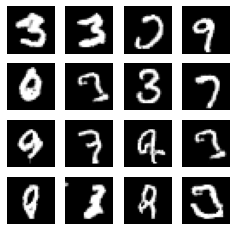

Epoch 79/100
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6154 - g_loss: 0.9545


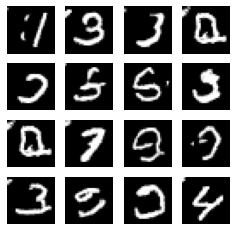

Epoch 80/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6132 - g_loss: 0.9587


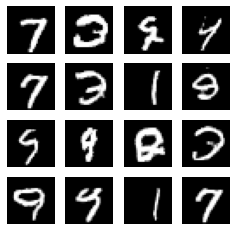

Epoch 81/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6168 - g_loss: 0.9551


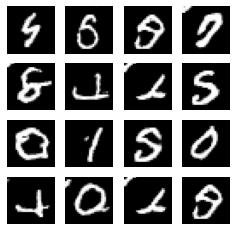

Epoch 82/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6156 - g_loss: 0.9643


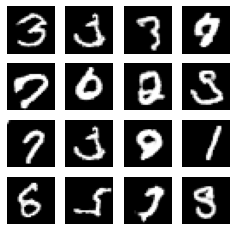

Epoch 83/100
100/100 [==============================] - 3s 32ms/step - d_loss: 0.6142 - g_loss: 0.9623


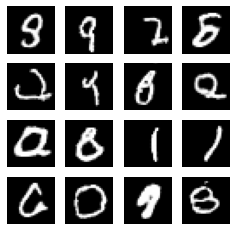

Epoch 84/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6150 - g_loss: 0.9714


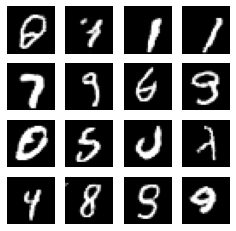

Epoch 85/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6172 - g_loss: 0.9530


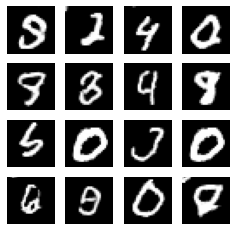

Epoch 86/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6184 - g_loss: 0.9559


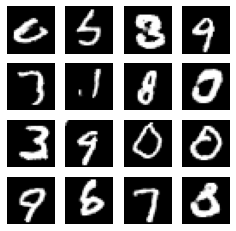

Epoch 87/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6188 - g_loss: 0.9539


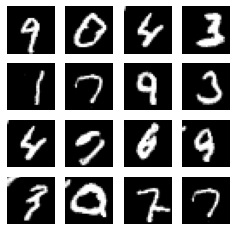

Epoch 88/100
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6165 - g_loss: 0.9623


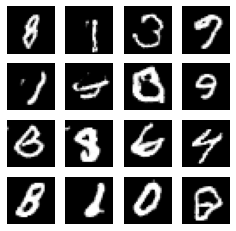

Epoch 89/100
100/100 [==============================] - 3s 34ms/step - d_loss: 0.6163 - g_loss: 0.9634


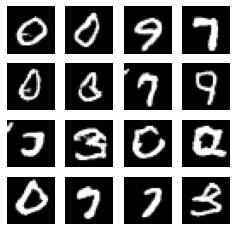

Epoch 90/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6152 - g_loss: 0.9538


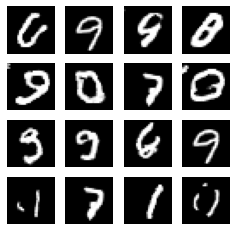

Epoch 91/100
100/100 [==============================] - 4s 39ms/step - d_loss: 0.6189 - g_loss: 0.9583


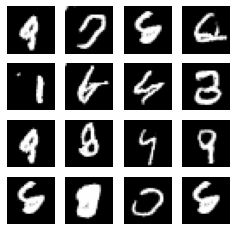

Epoch 92/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6207 - g_loss: 0.9634


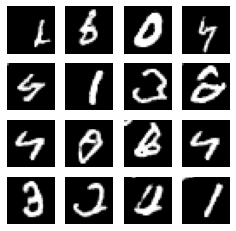

Epoch 93/100
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6179 - g_loss: 0.9531


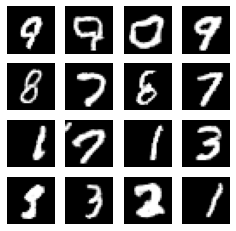

Epoch 94/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6213 - g_loss: 0.9596


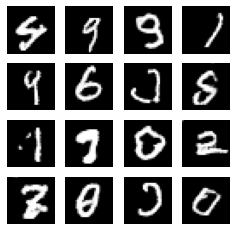

Epoch 95/100
100/100 [==============================] - 4s 35ms/step - d_loss: 0.6137 - g_loss: 0.9610


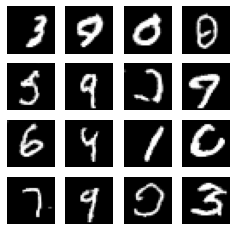

Epoch 96/100
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6196 - g_loss: 0.9577


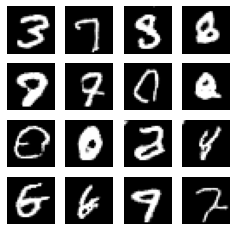

Epoch 97/100
100/100 [==============================] - 4s 37ms/step - d_loss: 0.6178 - g_loss: 0.9515


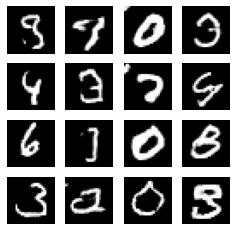

Epoch 98/100
100/100 [==============================] - 3s 35ms/step - d_loss: 0.6171 - g_loss: 0.9607


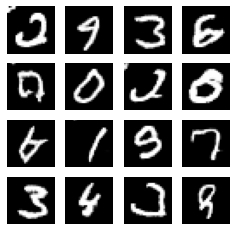

Epoch 99/100
100/100 [==============================] - 4s 36ms/step - d_loss: 0.6173 - g_loss: 0.9559


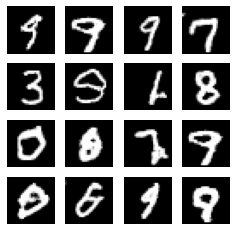

Epoch 100/100
100/100 [==============================] - 4s 39ms/step - d_loss: 0.6172 - g_loss: 0.9600


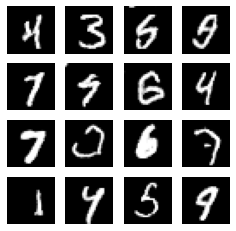

In [94]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 128
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

logdir = 'gan-logdir/tf_mnist/'
isaveimg = SaveImagesCallback(logdir= logdir)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, batch_size= batch_size)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset.take(100), epochs=100, callbacks= [isaveimg])